In [59]:
import json
from io import StringIO
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_customer_train = pd.read_csv('..\\data\\tinkoff\\customer_train.csv')
df_stories_description = pd.read_csv('..\\data\\tinkoff\\stories_description.csv')
df_transactions = pd.read_csv('..\\data\\tinkoff\\transactions.csv')

In [9]:
example_story = json.load(StringIO(df_stories_description.iloc[0]['story_json']))

In [24]:
example_story.keys()

dict_keys(['guid', 'type', 'description', 'properties', 'content'])

In [25]:
df_transactions

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,855115,7,3,1500,4554547,5411
1,997036,6,6,0,1657528,5411
2,398237,5,24,2500,26375569,5813
3,997036,6,2,0,16304402,5411
4,291636,7,25,0,1259505,5411
...,...,...,...,...,...,...
3951110,153986,6,30,29500,92701772,5719
3951111,346407,6,18,500,120278116,4816
3951112,358612,6,6,2500,111686898,5691
3951113,346407,6,7,500,2765037,5411


In [27]:
df_transactions[['transaction_amt', 'merchant_mcc']].describe()

,transaction_amt,merchant_mcc
count,3.951115e+06,3.951115e+06
mean,9.767657e+02,5.584733e+03
std,4.674880e+03,7.599550e+02
min,0.000000e+00,1.520000e+03
25%,0.000000e+00,5.411000e+03
50%,5.000000e+02,5.499000e+03
75%,5.000000e+02,5.814000e+03
max,1.854500e+06,9.405000e+03


Обратил внимание, что очень много транзакций с суммой перевода равной нулю

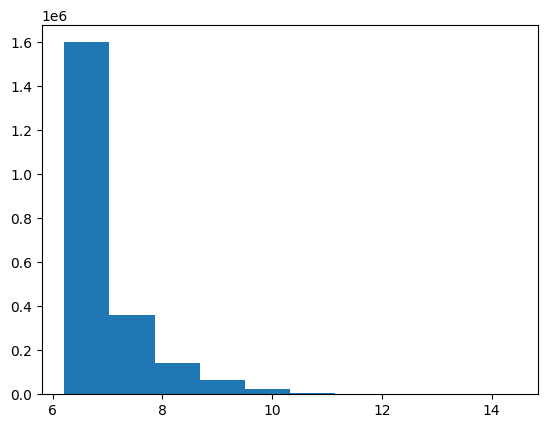

In [36]:
plt.hist(np.log(df_transactions[df_transactions['transaction_amt'] != 0]['transaction_amt']));

In [39]:
df_transactions[df_transactions['transaction_amt'] == 0]['transaction_amt'].count()

1751628

In [40]:
df_transactions[df_transactions['transaction_amt'] == 0]

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
1,997036,6,6,0,1657528,5411
3,997036,6,2,0,16304402,5411
4,291636,7,25,0,1259505,5411
7,862192,7,14,0,65419694,5814
8,862192,5,26,0,97570081,5411
...,...,...,...,...,...,...
3951098,289468,6,2,0,77187702,4121
3951099,603825,6,4,0,77187702,4121
3951102,561987,7,8,0,77187702,4121
3951103,561987,7,1,0,7653547,5499


Так как у нас нет никого описания датасета, предположим, что это NaN транзакции и просто дропнем их

In [42]:
df_transactions.drop(
    index=df_transactions[df_transactions['transaction_amt'] == 0].index,
    axis=1,
    inplace=True
)

In [60]:
df_transactions['TRDATETIME'] = \
    df_transactions[['transaction_month', 'transaction_day']].apply(
        lambda x: '.'.join(chain(('2020',), map(str, x))),
        axis=1
    )

In [62]:
df_transactions['TRDATETIME'] = pd.to_datetime(
    df_transactions['TRDATETIME'], format='%Y.%m.%d'
)

In [63]:
df_transactions

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc,TRDATETIME
0,855115,7,3,1500,4554547,5411,2020-07-03
2,398237,5,24,2500,26375569,5813,2020-05-24
5,844503,5,24,3500,12790541,5411,2020-05-24
6,844503,6,22,3500,12790541,5411,2020-06-22
14,408749,6,12,1500,14334966,5211,2020-06-12
...,...,...,...,...,...,...,...
3951110,153986,6,30,29500,92701772,5719,2020-06-30
3951111,346407,6,18,500,120278116,4816,2020-06-18
3951112,358612,6,6,2500,111686898,5691,2020-06-06
3951113,346407,6,7,500,2765037,5411,2020-06-07
